In [4]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from model import ode_y, ode_y_jump_approach_one, ode_y_jump_approach_one_boundary
from model import solve_with_emission_boundary_check
from utilities import find_nearest_value
from numba import njit

import matplotlib as mpl

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

**ODE with predetermined emission**:
\begin{align*}
0 =  &  -\delta \phi(y) + \delta \eta \log \color{blue}{\tilde{e}} \\
&+ \left(\frac{d\phi(y)}{dy}+ (\eta-1)(\gamma_1 + \gamma_2 y)\right)\color{blue}{\tilde{e}}\sum_{i=1}^n \pi_i^c \theta_i\ \\
& + \frac{1}{2} \left(\frac{d^2 \phi(y)}{(d y)^2} + (\eta-1)\gamma_2\right)|\sigma_y|^2(\color{blue}{\tilde{e}})^2\\
\end{align*}

Marginal value of emission:
\begin{align*}
ME =  & - \left(\frac{d\phi(y)}{dy}+ (\eta-1)(\gamma_1 + \gamma_2 y)\right)\sum_{i=1}^n \pi_i^c \theta_i\ \\
& - \left(\frac{d^2 \phi(y)}{(d y)^2} + (\eta-1)\gamma_2\right)|\sigma_y|^2\color{blue}{\tilde{e}}\\
\end{align*}

In [5]:
ξ_1m = 1./400
ξ_2m = 1./20
ξ_a = 1./10000

η = .032
δ = .01

θ = pd.read_csv('../data/model144.csv', header=None).to_numpy()[:, 0]/1000.
πc_o = np.ones_like(θ)/len(θ)
σ_y = 1.2*1.86/1000

y_bar = 2.
γ_1 = 1.7675/10000
γ_2 = .0022*2

γ_2p = np.array([0, .0197*2, .3853*2])
πd_o = np.array([.475, .475, .05])

y_step = .04
y_grid_long = np.arange(0., 4., y_step)
y_grid_short = np.arange(0., 2+y_step, y_step)
n_bar = find_nearest_value(y_grid_long, y_bar) + 1

# Prepare ϕ
ϕ_list = []
for γ_2p_i in γ_2p:
    model_paras = (η, δ, θ, πc_o, σ_y, ξ_1m, ξ_a, γ_1, γ_2, γ_2p_i, y_bar) 
    model_res = ode_y(y_grid_long, model_paras, v0=None, ϵ=.5,
                       tol=1e-8, max_iter=10_000, print_all=False)
    ϕ_list.append(model_res['v0'])

ϕ_list_short = []
for ϕ_i in ϕ_list:
    temp = ϕ_i[:n_bar]
    ϕ_list_short.append(temp)
ϕ_i = np.array(ϕ_list_short)

# Compute ϕ
ς = .25
model_paras = (η, δ, θ, πc_o, σ_y, ξ_1m, ξ_2m, ξ_a, ς, γ_1, γ_2, y_bar, ϕ_i, πd_o)
model_res = ode_y_jump_approach_one_boundary(y_grid_short, model_paras, v0=np.average(ϕ_i, weights=πd_o, axis=0),
                                                    ϵ=.5, tol=1e-9, max_iter=10000, print_all=False)

Converged. Total iteration 1989: LHS Error: 9.985022919600794e-09; RHS Error 1.6264680024628613e-06
Converged. Total iteration 2081: LHS Error: 9.97927577378599e-09; RHS Error 8.222185655702295e-06
Converged. Total iteration 2313: LHS Error: 9.981253129565104e-09; RHS Error 3.7902347181765796e-05
Converged. Total iteration 10000: LHS Error: 3.6577357827305423e-07; RHS Error 5.268126565230143e-06


Iteration 1: LHS Error: 0.07127523164384666; RHS Error 0.006936082563495998
Iteration 2: LHS Error: 0.006596368147168041; RHS Error 0.006243775394577385
Iteration 3: LHS Error: 0.0059435603720978305; RHS Error 0.005625895080353551
Iteration 4: LHS Error: 0.005360365623380013; RHS Error 0.0050739481222331
Iteration 5: LHS Error: 0.004838892960848512; RHS Error 0.004580457275597291
Iteration 6: LHS Error: 0.004372191012503366; RHS Error 0.004138835282521325
Iteration 7: LHS Error: 0.003954130947002067; RHS Error 0.003743274830319553
Iteration 8: LHS Error: 0.003579305426215865; RHS Error 0.003388652523076944
Iteration 9: LHS Error: 0.0032429401011454854; RHS Error 0.0030704450336006897
Iteration 10: LHS Error: 0.00294081687802293; RHS Error 0.0027846559181645626
Iteration 11: LHS Error: 0.0027635108543535777; RHS Error 0.0025277515621799506
Iteration 12: LHS Error: 0.0027150310419131202; RHS Error 0.0024508679453844498
Iteration 13: LHS Error: 0.002652246134695205; RHS Error 0.0023848838

Iteration 282: LHS Error: 0.0003483109785735785; RHS Error 0.0003401379711394571
Iteration 283: LHS Error: 0.0003469384714827976; RHS Error 0.0003387663675651613
Iteration 284: LHS Error: 0.0003455053173497674; RHS Error 0.0003373366984099541
Iteration 285: LHS Error: 0.00034410108507486326; RHS Error 0.0003361731190420245
Iteration 286: LHS Error: 0.00034291338549832795; RHS Error 0.00033498006829024035
Iteration 287: LHS Error: 0.0003416665027054788; RHS Error 0.00033373028191661415
Iteration 288: LHS Error: 0.00034036082250686606; RHS Error 0.0003324241453841961
Iteration 289: LHS Error: 0.000338996787202552; RHS Error 0.00033106209803059587
Iteration 290: LHS Error: 0.00033757489433202303; RHS Error 0.0003297971365534946
Iteration 291: LHS Error: 0.0003363680074336869; RHS Error 0.0003286568356612375
Iteration 292: LHS Error: 0.0003351769614577671; RHS Error 0.000327461983573026
Iteration 293: LHS Error: 0.00033392937950751933; RHS Error 0.00032621291308933416
Iteration 294: LHS Er

Iteration 557: LHS Error: 4.774091495902503e-06; RHS Error 6.814693023986891e-06
Iteration 558: LHS Error: 4.62864848819559e-06; RHS Error 6.810952453402549e-06
Iteration 559: LHS Error: 4.487289287577467e-06; RHS Error 6.807326274533491e-06
Iteration 560: LHS Error: 4.3499127386677685e-06; RHS Error 6.803810427327185e-06
Iteration 561: LHS Error: 4.2164196977639845e-06; RHS Error 6.800401039134955e-06
Iteration 562: LHS Error: 4.086713011168993e-06; RHS Error 6.79709442140354e-06
Iteration 563: LHS Error: 3.960697492246442e-06; RHS Error 6.793887059200292e-06
Iteration 564: LHS Error: 3.83827989884622e-06; RHS Error 6.790775602785889e-06
Iteration 565: LHS Error: 3.7193689096196953e-06; RHS Error 6.787756859363283e-06
Iteration 566: LHS Error: 3.60387510033496e-06; RHS Error 6.78482778455761e-06
Iteration 567: LHS Error: 3.4917109197988667e-06; RHS Error 6.781985478244935e-06
Iteration 568: LHS Error: 3.3827906651314374e-06; RHS Error 6.779227173674346e-06
Iteration 569: LHS Error: 3.

(0.0, 1.0)

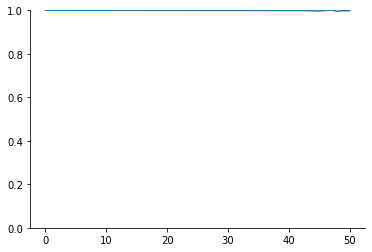

In [6]:
e_tilde = model_res['e_tilde']

# Compute marginal values for emission (under distorted probabilities)
ME_distorted = δ*η/e_tilde

# Compute marginal values for emission (under baseline probabilities)
model_paras_new = (η, δ, θ, πc_o, σ_y, γ_1, γ_2, ϕ_i, πd_o, e_tilde, model_res['h'], model_res['πc'], model_res['bc'], ξ_1m, ξ_2m, ξ_a)
model_res_new = solve_with_emission_boundary_check(y_grid_short, model_paras_new)

ME_baseline = model_res_new['ME']
plt.plot(ME_baseline/ME_distorted)
plt.ylim(0, 1)